In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_many_images(images, titles, rows=1, columns=2):
	"""Plots each image in a given list in a grid format using Matplotlib."""
	for i, image in enumerate(images):
		plt.subplot(rows, columns, i+1)
		plt.imshow(image, 'gray')
		plt.title(titles[i])
		plt.xticks([]), plt.yticks([])  # Hide tick marks
	plt.show()

In [3]:
def pre_process_image(img, skip_dilate=False):
    proc = cv2.GaussianBlur(img.copy(), (9, 9), 0)
    proc = cv2.adaptiveThreshold(proc, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    proc = cv2.bitwise_not(proc, proc)

    #if not skip_dilate:
    #    kernel = np.array([[0,1,0],[1,1,1],[0,1,0]],np.uint8)
    #    proc = cv2.dilate(proc, kernel,iterations=1)
    
    return proc

In [4]:
import operator

def find_corners_of_largest_polygon(img):
	"""Finds the 4 extreme corners of the largest contour in the image."""
	contours,_ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
	contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
	polygon = contours[0]  # Largest image


	bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
	top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))


	return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]




In [5]:
def display_points(in_img, points, radius=5, colour=(0, 0, 255)):
	"""Draws circular points on an image."""
	img = in_img.copy()

	# Dynamically change to a colour image if necessary
	if len(colour) == 3:
		if len(img.shape) == 2:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
		elif img.shape[2] == 1:
			img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

	for point in points:
		img = cv2.circle(img, tuple(int(x) for x in point), radius, colour, -1)
	return img

In [6]:
def distance_between(p1, p2):
	"""Returns the scalar distance between two points"""
	a = p2[0] - p1[0]
	b = p2[1] - p1[1]
	return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(img, crop_rect):
	"""Crops and warps a rectangular section from an image into a square of similar size."""

	# Rectangle described by top left, top right, bottom right and bottom left points
	top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

	# Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
	src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

	# Get the longest side in the rectangle
	side = max([
		distance_between(bottom_right, top_right),
		distance_between(top_left, bottom_left),
		distance_between(bottom_right, bottom_left),
		distance_between(top_left, top_right)
	])

	# Describe a square with side of the calculated length, this is the new perspective we want to warp to
	dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')

	# Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
	m = cv2.getPerspectiveTransform(src, dst)

	# Performs the transformation on the original image
	return cv2.warpPerspective(img, m, (int(side), int(side)))


In [7]:
def infer_grid(img):
	"""Infers 81 cell grid from a square image."""
	squares = []
	side = img.shape[:1]
	side = side[0] / 9
	for i in range(9):
		for j in range(9):
			p1 = (i * side, j * side)  # Top left corner of a bounding box
			p2 = ((i + 1) * side, (j + 1) * side)  # Bottom right corner of bounding box
			squares.append((p1, p2))
	return squares


In [8]:
def display_rects(in_img, rects, colour=255):
	"""Displays rectangles on the image."""
	img = in_img.copy()
	for rect in rects:
		img = cv2.rectangle(img, tuple(int(x) for x in rect[0]), tuple(int(x) for x in rect[1]), colour)
	plot_many_images([img],['fasak'])
	return img

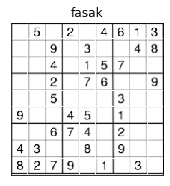

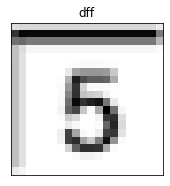

In [21]:
img = cv2.imread('sudoku3.png', cv2.IMREAD_GRAYSCALE)
processed = pre_process_image(img)
corners = find_corners_of_largest_polygon(processed)
cropped = crop_and_warp(img, corners)
squares = infer_grid(cropped)
img=display_rects(cropped, squares)
resized = cv2.resize(img, (180,180), interpolation = cv2.INTER_AREA)
img=resized[:20,20:40]
plot_many_images([img],["dff"])